### Imports

In [1]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Data Ingest

In [2]:
# read raw data
orgdata = pd.read_csv(
  "data/crimes.csv", 
  usecols=["DATE OF OCCURRENCE", "FBI CD", "beat_num"],
  parse_dates=["DATE OF OCCURRENCE"]
)


/tmp/ipykernel_17408/2120724538.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  orgdata = pd.read_csv(


In [3]:

# filter for trailing twelve months and only violent crime
data = orgdata[
  (orgdata["DATE OF OCCURRENCE"] > "2022-09-13 00:00:00") &
  (orgdata["FBI CD"].isin(["01A", "02", "03", "04A", "04B"]))]

# get shapefile for CPD beats
types = {
  "beat": int,
  "beat_num": int,
  "district": int,
  "sector": int,
}
beats = gpd.read_file("maps/geo_export_cf56fcdf-4e4b-485b-83b8-f76287821f6a.shp").astype(types)

#### Verification

In [4]:
data

DATE OF OCCURRENCE  beat_num FBI CD
79     2022-12-28 10:00:00      1214    04B
92     2022-10-25 13:00:00      1722     02
109    2023-08-31 19:00:00       833    04B
170    2022-11-26 06:15:00       113     03
188    2022-12-08 15:38:00      1834    01A
...                    ...       ...    ...
256904 2023-02-04 12:29:00      2234     03
256913 2023-03-22 10:47:00       731    04B
256925 2022-11-12 18:35:00       512    04B
256931 2023-07-31 00:00:00       312    04B
256933 2023-06-18 01:05:00      1824    04B

[27466 rows x 3 columns]

In [5]:

data.info()
            

<class 'pandas.core.frame.DataFrame'>
Index: 27466 entries, 79 to 256933
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE OF OCCURRENCE  27466 non-null  datetime64[ns]
 1   beat_num            27466 non-null  int64         
 2   FBI CD              27466 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 858.3+ KB


In [6]:
beats.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   beat      277 non-null    int64   
 1   beat_num  277 non-null    int64   
 2   district  277 non-null    int64   
 3   sector    277 non-null    int64   
 4   geometry  277 non-null    geometry
dtypes: geometry(1), int64(4)
memory usage: 10.9 KB


<Axes: >

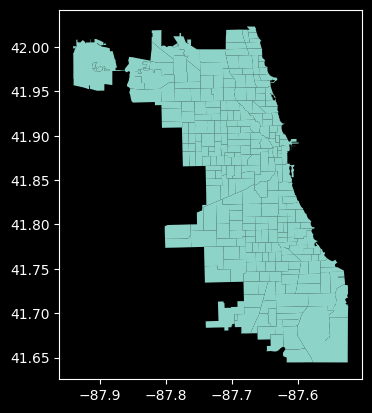

In [7]:
beats.plot(legend=False)

### Processing

In [8]:
# count number of occurrances in each beat
per_beat = data["beat_num"].value_counts().reset_index(name="count")
per_beat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   beat_num  274 non-null    int64
 1   count     274 non-null    int64
dtypes: int64(2)
memory usage: 4.4 KB


In [9]:
# merge shapefile and beat data
beat_map = beats.merge(per_beat, on="beat_num")
beat_map.head()

beat  beat_num  district  sector  \
0     1      1713        17       1   
1     5      1651        16       5   
2     1      1914        19       1   
3     1      1915        19       1   
4     1      1913        19       1   

                                            geometry  count  
0  POLYGON ((-87.70473 41.97577, -87.70472 41.975...     47  
1  POLYGON ((-87.90684 41.97656, -87.91070 41.975...     12  
2  POLYGON ((-87.64492 41.96973, -87.64431 41.969...    103  
3  POLYGON ((-87.63724 41.96599, -87.63644 41.965...     55  
4  POLYGON ((-87.65967 41.96903, -87.65967 41.968...     67

In [10]:
mean = beat_map["count"].mean()
beat_map["deviations"] = beat_map.apply(lambda row: row["count"] - mean, axis=1)
beat_map

beat  beat_num  district  sector  \
0       1      1713        17       1   
1       5      1651        16       5   
2       1      1914        19       1   
3       1      1915        19       1   
4       1      1913        19       1   
..    ...       ...       ...     ...   
269     1       314         3       1   
270     2       825         8       2   
271     1       313         3       1   
272     2       823         8       2   
273     1       312         3       1   

                                              geometry  count  deviations  
0    POLYGON ((-87.70473 41.97577, -87.70472 41.975...     47  -53.240876  
1    POLYGON ((-87.90684 41.97656, -87.91070 41.975...     12  -88.240876  
2    POLYGON ((-87.64492 41.96973, -87.64431 41.969...    103    2.759124  
3    POLYGON ((-87.63724 41.96599, -87.63644 41.965...     55  -45.240876  
4    POLYGON ((-87.65967 41.96903, -87.65967 41.968...     67  -33.240876  
..                                                 ...    ...         ...  
269  POLYGON ((-87.58879 41.78612, -87.58844 41.786...     79  -21.240876  
270  POLYGON ((-87.67917 41.78656, -87.67912 41.784...    129   28.759124  
271  POLYGON ((-87.60854 41.78583, -87.60808 41.785...     98   -2.240876  
272  POLYGON ((-87.69354 41.78458, -87.69354 41.784...    185   84.759124  
273  POLYGON ((-87.60431 41.78043, -87.60400 41.780...    148   47.759124  

[274 rows x 7 columns]

<GeoAxes: title={'center': "Violent Crime Occurrances Difference from Mean, TTM Sep '23"}>

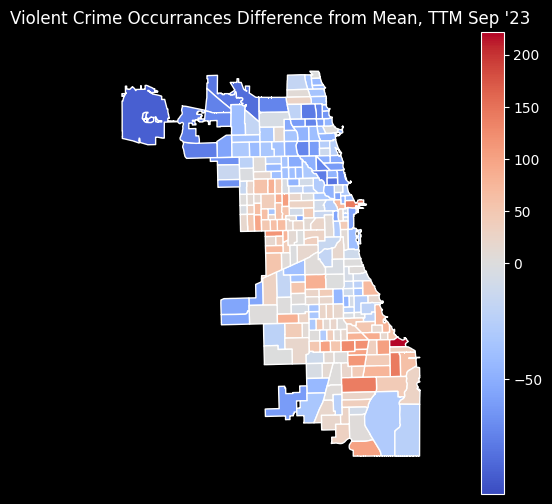

In [17]:

ax = gplt.polyplot(beat_map, projection=gcrs.AlbersEqualArea())
ax.set_title("Violent Crime Occurrances Difference from Mean, TTM Sep '23")
gplt.choropleth(
  beat_map,
  hue="deviations",
  edgecolor="white",
  linewidth=1,
  legend=True,
  norm=mpl.colors.TwoSlopeNorm(vmin=beat_map["deviations"].min(), vcenter=0, vmax=beat_map["deviations"].max()),
  cmap="coolwarm",
  ax=ax,
)